<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>Market Response Modeling</center></h1>

In [20]:
# !pip install scikit-learn-extra

In [21]:
# pip install catboost

In [22]:
# pip install scikit-plot

In [23]:
# pip install optuna

In [24]:
import numpy as np
from imblearn.combine import SMOTETomek
from numpy import isnan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from datetime import date
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler,RobustScaler

# from sklearn_extra.cluster import KMedoids

from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.metrics import classification_report,confusion_matrix
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from functools import partial
from sklearn.feature_selection import VarianceThreshold
from optuna import Trial, visualization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,f_classif
import collections
from collections import Counter
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')


# import os
# !ls ../input/
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# data_folder = "/kaggle/input/arketing-campaign/"
# dataset=pd.read_csv(data_folder+'marketing_campaign.csv',header=0,sep=';') 

In [25]:
import sklearn
print(sklearn.__version__)

1.6.1


In [26]:
data_folder = "../data/"
dataset=pd.read_csv(data_folder+'marketing_campaign.csv',header=0,sep=';') 

### Table of Contents

* [1. Data Preprocessing](#section_1)
    * [A. Custom transformers creation](#section_1_1)
    * [B. Data types and data completeness](#section_1_2)
    * [C. Class distribution](#section_1_3)
    * [D. Feature engineering](#section_1_4)
    * [E. Feature selection](#section_1_5)
    
    ___
* [2. Model Creation](#section_2)
    * [A. Evaluate algorithm baseline performance with nested cross-validation](#section_2_1)
    * [B. Hyperparameter tuning with Optuna](#section_2_2)
    
    ---
* [3. Model results](#section_3)
    * [A. Visual Hyperparameter Optimization Analysis](#section_3_1)
    * [B. Model Evaluation Metrics and Confusion Matrix](#section_3_2)
    * [C. Cumulative Gains and Lift charts](#section_3_3)
    
    ---

# 1. Data Preprocessing <a class="anchor" id="section_1"></a>

### A. Custom transformers creation <a class="anchor" id="section_1_1"></a>

#### Feature type selection (click to view code)

In [27]:
class feat_sel(BaseEstimator, TransformerMixin):
    def __init__(self, dtype='numeric'):
        self.dtype = dtype

    def fit( self, X, y=None ):
        return self 

    def transform(self, X, y=None):
        if self.dtype == 'numeric':
            num_cols = X.columns[X.dtypes != object].tolist()
            return X[num_cols]
        elif self.dtype == 'category':
            cat_cols = X.columns[X.dtypes == object].tolist()
            return X[cat_cols]
    def get_feature_names(self):
        if self.dtype == 'numeric':
            num_cols = X.columns[X.dtypes != object].tolist()
            return X[num_cols]
        elif self.dtype == 'category':
            cat_cols = X.columns[X.dtypes == object].tolist()
            return X[cat_cols]

 #### Label encoder (click to view code)

In [28]:
class Label_encode(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        #Ordinal encoding by LTV values : Champions have highest LTV followed by Loyal customers etc...
            #(see previous notebook called "RFM segmentation and CLV modeling" if needed)
        X['Segment']=X['Segment'].replace({'Champions':9,'Loyal customers':8,'Cant loose them':7,'At risk':6,
                                           'Potential loyalist':5,'Need attention':4,'Promising':3,'New customers':2,
                                           'About to sleep':1,'Lost':0}, regex=True)
        #1=In couple, 0=Alone
        X['Marital_Status']=X['Marital_Status'].replace({'Divorced':0,'Single':0,
                                                                        'Married':1,'Together':1,                                                  
                                                         'Absurd':0,'Widow':0,'YOLO':0,'Alone':0}, regex=True)
        self.columns = X.columns
        return X
    def get_feature_names(self):
        return list(self.columns)

#### Power transformation (click to view code)

In [29]:
class df_unskewed(TransformerMixin,BaseEstimator):
    
    def __init__(self, method='yeo-johnson'):
        
        self.method = method
        self.standardize=False #Standardize = False as we use the custom class "df_scaler"

    def fit(self, X, y=None):
        if self.method == 'yeo-johnson':
            self.scl = PowerTransformer(method=self.method,standardize=False)
            self.scl.fit(X)
            return self
        elif self.method == 'None':
            return self

    def transform(self, X):
        if self.method == 'yeo-johnson':
            Xscl = self.scl.transform(X)
            Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
            self.columns = X.columns
            return Xscaled
        elif self.method == 'None':
            Xscl = X
            Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
            self.columns = X.columns
            return Xscaled
    def get_feature_names(self):
        return list(self.columns)

#### Feature scaling (click to view code)

In [30]:
class df_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, method=StandardScaler()):
        super().__init__()
        self.method = method        

    def fit(self, X, y=None):
        return self.method.fit(X)

    def transform(self, X, y=None):
        Xscl = self.method.transform(X)
        Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
        self.columns = X.columns
        return Xscaled
    def get_feature_names(self):
        return list(self.columns)  

#### FeatureUnion (click to view code)

In [31]:
class FeatureUnion_df(TransformerMixin, BaseEstimator):
    
    def __init__(self, transformer_list, n_jobs=None, transformer_weights=None, verbose=False):
        self.transformer_list = transformer_list
        self.n_jobs = n_jobs
        self.transformer_weights = transformer_weights
        self.verbose = verbose  
        self.feat_un = FeatureUnion(self.transformer_list, 
                                    n_jobs = self.n_jobs, 
                                    transformer_weights = self.transformer_weights, 
                                    verbose = self.verbose)
    def fit(self, X, y=None):
        self.feat_un.fit(X)
        return self

    def transform(self, X, y=None):
        X_tr = self.feat_un.transform(X)
        columns = []
        
        for trsnf in self.transformer_list:
            cols = trsnf[1].steps[-1][1].get_feature_names()  
            columns += list(cols)

        X_tr = pd.DataFrame(X_tr, index=X.index, columns=columns)
        
        return X_tr

    def get_params(self, deep=True): 
        return self.feat_un.get_params(deep=deep)
    def get_feature_names(self):
        return self.columns

#### Model selection (click to view code)

In [32]:
class Model_selection(BaseEstimator):
    def __init__(self, estimator = CatBoostClassifier()):
        self.estimator = estimator
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self
    def predict(self, X, y=None):
        return self.estimator.predict(X)
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    def score(self, X, y):
        return self.estimator.score(X, y)

### A. Data types and data completeness <a class="anchor" id="section_1_1"></a>

In [33]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Using the __*info function*__, we can pull the following information from our dataset :
>- We have __3 categorical variables__ and __26 numerical variables__
>- We have __missing values__ for the __*Income*__ variable

As a result : __Imputing missing values__ and __encoding catgorical features__ may be necessary if features are kept for prediction

### B. Class distribution <a class="anchor" id="section_1_2"></a>

On classification problems, analyzing the class distribution is always an important step as highly imbalanced data are common and need special treatment.  
Let's check if data are imbalanced :

In [34]:
target = dataset['Response']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.2f%%' % (k, v, per))

Class=1, Count=334, Percentage=14.91%
Class=0, Count=1906, Percentage=85.09%


The dataset is imbalanced. We will have to add a resampling step in our pipeline.  
We will use the SMOTETomek technique which combine a synthetic oversampling sequence (SMOTE) followed by an undersampling sequence (TOMEK)  
**Step 1 :** Oversampling synthetically the minority class  
**Step 2 :** Undersampling by cleaning the noise generated by the SMOTE technique

### C. Feature Engineering <a class="anchor" id="section_1_3"></a>

In [35]:
dataset.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,2013-09-09,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,2012-11-13,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,2013-05-08,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,...,20,1,0,0,0,0,0,3,11,0


Having a first look at the row data enables us to start thinking at some useful variables we could create in order to better understand our dataset and reveal precious information.  

We will create several variables :

>- Variable __*Seniority*__ as the number of months the customer is enrolled with the company
>- Variable __*Educationnal years*__ as the total number of years of education the individual achieved according to its diploma
>- Variable __*Accepted offers*__ as the total number of offers accepted during the 5 past marketing campaigns
>- Variable __*Segment*__ created from the <a href="https://www.kaggle.com/raphael2711/rfm-segmentation-and-clv-modeling">RFM segmentation </a>  

As seen in the <a href="https://www.kaggle.com/raphael2711/data-prep-visual-eda-and-statistical-hypothesis">previous notebooks</a>, we will remove the outlier in *Income* variable along with removing unused variables

In [36]:
#features creation
last_date = date(2014,10, 4)
dataset['Seniority']=pd.to_datetime(dataset['Dt_Customer'], dayfirst=True,format = '%Y-%m-%d')
dataset['Seniority'] = pd.to_numeric(dataset['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30
dataset['Accepted_offers']=dataset['AcceptedCmp1']+dataset['AcceptedCmp2']+dataset['AcceptedCmp3']+dataset['AcceptedCmp4']+dataset['AcceptedCmp5']
dataset['Educationnal_years']=dataset['Education'].replace({'Basic':5,'2n Cycle':8,'Graduation':12,'Master':18,'PhD':21})
dataset = dataset[dataset['NumWebPurchases']+dataset['NumCatalogPurchases']+dataset['NumStorePurchases'] > 0]
dataset=dataset.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Education','Dt_Customer','Z_CostContact','Z_Revenue'])
#1.Outliers removal
dataset = dataset.drop(dataset[dataset['Income']> 600000].index).reset_index(drop=True)

### RFM calculation

In [37]:
#1.Dataframe creation
recency_df = dataset[['ID','Recency']]
frequency_df = dataset[['ID','NumWebPurchases','NumCatalogPurchases','NumStorePurchases']]
frequency_df['Transactions']=frequency_df['NumWebPurchases']+frequency_df['NumCatalogPurchases']+frequency_df['NumStorePurchases']
frequency_df=frequency_df.drop(columns=['NumWebPurchases','NumCatalogPurchases','NumStorePurchases'])

temp_df = recency_df.merge(frequency_df,on='ID')
monetary_df = dataset[['ID','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']]
monetary_df['Spending']=monetary_df['MntWines']+dataset['MntFruits']+dataset['MntMeatProducts']+dataset['MntFishProducts']+dataset['MntSweetProducts']+dataset['MntGoldProds']
monetary_df=monetary_df.drop(columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds'])
RFM=recency_df.merge(frequency_df,on='ID').merge(monetary_df,on='ID')
RFM.columns = ['ID','Recency','Frequency','Monetary']

#2.Clusters creation
kmedoids_recency = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Recency']])
RFM['RecencyCluster'] = kmedoids_recency.predict(RFM[['Recency']])
kmedoids_frequency = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Frequency']])
RFM['FrequencyCluster'] = kmedoids_frequency.predict(RFM[['Frequency']])
kmedoids_monetary = KMedoids(n_clusters=5, random_state=0, max_iter=1000,init='k-medoids++',metric='euclidean').fit(RFM[['Monetary']])
RFM['MonetaryCluster'] = kmedoids_monetary.predict(RFM[['Monetary']])

3.#Clusters ordering
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

RFM = order_cluster('RecencyCluster', 'Recency',RFM,False)
RFM = order_cluster('FrequencyCluster', 'Frequency',RFM,True)
RFM = order_cluster('MonetaryCluster', 'Monetary',RFM,True)


#4.Segments creation
segt_map = {
    r'30': 'Promising',
    r'23': 'Loyal customers',
    r'24': 'Loyal customers',
    r'33': 'Loyal customers',
    r'34': 'Loyal customers',
    r'43': 'Loyal customers',
    r'32': 'Potential loyalist',
    r'31': 'Potential loyalist',
    r'42': 'Potential loyalist',
    r'41': 'Potential loyalist',
    r'21': 'Need attention',
    r'22': 'Need attention',
    r'12': 'Need attention',
    r'11': 'Need attention',
    r'40': 'New customers',
    r'20': 'About to sleep',
    r'14': 'Cant loose them',
    r'04': 'Cant loose them',
    r'10': 'Lost',
    r'00': 'Lost',
    r'01': 'Lost',
    r'02': 'At risk',
    r'03': 'At risk',
    r'13': 'At risk',
    r'44': 'Champions',
}
#We create the segment and merge with our main dataset
RFM['Segment'] = RFM['RecencyCluster'].map(str) + RFM['FrequencyCluster'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
dataset=dataset.merge(RFM[['ID','Segment']],on='ID')

NameError: name 'KMedoids' is not defined

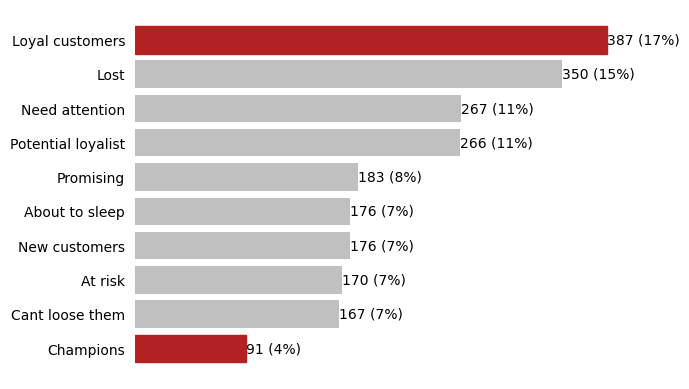

In [81]:
# count the number of customers in each segment
segments_counts = dataset['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Champions', 'Loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
plt.show()

### D. Skew of univariate distribution <a class="anchor" id="section_1_4"></a>

In [82]:
num_feats=dataset.dtypes[dataset.dtypes!='object'].index
skew_feats=dataset[num_feats].skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_feats})
print('We have {} skewed numerical features'.format(skewness[abs(skewness) > 0.75].shape[0]))
display(skewness.style.background_gradient(cmap = 'Reds', axis = 0))

We have 22 skewed numerical features


,Skew
Complain,10.172602
Accepted_offers,2.716985
NumDealsPurchases,2.319934
MntSweetProducts,2.131652
MntFruits,2.097533
MntMeatProducts,2.079495
Response,1.966394
MntFishProducts,1.915384
MntGoldProds,1.882951
NumCatalogPurchases,1.878763


We will add a power transform step in our pipeline. Depending on the selected model, making data more Gaussian-like could improve the obtained performance

### E. Feature Selection <a class="anchor" id="section_1_5"></a>

Feature selction enables us to :
>- Remove redundant data leading to reducing overfitting
>- Remove irrelevant data leading to improving accuracy
>- Reduce number of features leading to faster training time

Variance analysis, correlation analysis and multicollinearity analysis will be done.   
Univariate feature selection will be done with ANOVA F-value calculation and will be integrated in the gridsearching process

### Feature variance analysis

Features with low variances are believed to contain very few information as they are approximatively constant and will probably not improve the performance of the model

In [83]:
Features = []
val=[]
var=[]
X=dataset.drop(columns=['Segment','Marital_Status','Response'])

for column in X:
    most_freq_value = np.round((X[column].value_counts(normalize = True).iloc[0])*100, 2)
    variance=X[column].var()
    Features.append(column)
    val.append(most_freq_value)
    var.append(variance)
count = pd.DataFrame(list(zip(Features, val,var)), columns =['Feature', 'Count%','Variance']).sort_values(ascending=False,by='Count%')
display(count.style.background_gradient(cmap = 'Reds', axis = 0,subset='Count%'))

,Feature,Count%,Variance
17,Complain,99.060000,0.009320
19,Accepted_offers,79.270000,0.461365
3,Kidhome,57.730000,0.290013
4,Teenhome,51.590000,0.296652
20,Educationnal_years,50.250000,20.352580
12,NumDealsPurchases,43.440000,3.590287
14,NumCatalogPurchases,25.970000,8.550965
15,NumStorePurchases,21.900000,10.507980
10,MntSweetProducts,18.670000,1707.239112
7,MntFruits,17.870000,1585.069898


We can see that "Complain" variable has a variance almost equal to 0 and that 99% of the rows have the same value.  
We will therefore remove it.

### Correlation analysis

Correlation refers to the relationship between two variables and how they move together.  

In [84]:
# # Finding the relations between the variables.
# plt.figure(figsize=(20,10))
# c= dataset.corr(method='spearman')
# sns.heatmap(c,annot=True);

We can see the variable *Income* has a high correlation with other variables. This can inform us of the presence of multicollinearity.

### Multicollinearity analysis

To detect multicollinearity, we will use the __*Variable Inflation Factors*__ method (VIF). It measures the strength of the correlation between our independant variables.  
We set our max threshold at 10

In [85]:
#Filter on non null value and exclude categoricals + target + Complain (because will be removed as seen earlier)
VIF = dataset[dataset['Income'].notnull()].drop(columns=['Segment','Marital_Status','Response','Complain'])
vif_data = pd.DataFrame()
vif_data["Feature"] = VIF.columns
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(VIF.values, i) for i in range(len(VIF.columns))]
vif_data=vif_data.sort_values(by='VIF',ascending=False)
vif_data.style.background_gradient(cmap = 'Reds', axis = 0)

,Feature,VIF
1,Year_Birth,60.754982
2,Income,32.860941
16,NumWebVisitsMonth,17.777929
19,Educationnal_years,13.278072
15,NumStorePurchases,10.207984
17,Seniority,8.087439
13,NumWebPurchases,6.710313
6,MntWines,6.354739
14,NumCatalogPurchases,5.655007
8,MntMeatProducts,4.958247


We can see that *NumStorePurchases*, *NumWebVisitsMonth*, *Year_Birth*, *Income* and *Educationnal_years* have high VIF.  
>- As presumed, the high correlation coefficient of Income result in a high VIF
>- We assume Year_Birth to be a variable that can be easily predicted by others like Kidhome, Teenhome, Income...  

We will remove the variable Year_Birth and Income and recheck if the VIF of other variables dropped

In [86]:
#We remove Year_Birth + Income and recalculate the VIF of other features 
VIF_filter=dataset.drop(columns=['Income','Segment','Marital_Status','Response','Complain','Year_Birth'])
vif_filtered_data = pd.DataFrame() 
vif_filtered_data["Feature"] = VIF_filter.columns 
vif_filtered_data["VIF"] = [variance_inflation_factor(VIF_filter.values, i) for i in range(len(VIF_filter.columns))]
#Filter to variables with VIF greater than 5 as the others are ok
vif_filtered_data=vif_filtered_data[vif_filtered_data["VIF"] > 5]
vif_filtered_data=vif_filtered_data.sort_values(by='VIF',ascending=False)
vif_filtered_data.style.background_gradient(cmap = 'Reds', axis = 0)

,Feature,VIF
14,NumWebVisitsMonth,11.333074
17,Educationnal_years,8.988499
13,NumStorePurchases,8.512775
15,Seniority,7.914376
11,NumWebPurchases,6.129052
4,MntWines,5.557228
12,NumCatalogPurchases,5.308098


We can see that VIF of *Educational_years* decreased. Nonetheless, the VIF of *NumWebVisitsMonth* remains above 10.  
As this variable is not a direct aggregation of others variables, we decide to remove this single variable and keep the others.

`Nota Bene : From here, we will also remove the variable ID as it's the unique identifier of the customer and it will be useless for the classification model`

In [87]:
dataset=dataset.drop(columns=['Income','NumWebVisitsMonth','ID','Complain','Year_Birth'])
#Final dataset before modeling
dataset

,Marital_Status,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Response,Seniority,Accepted_offers,Educationnal_years,Segment
0,Single,0,0,58,635,88,546,172,88,88,3,8,10,4,1,25.333333,0,12,Loyal customers
1,Single,1,1,38,11,1,6,2,1,6,2,1,1,2,0,7.000000,0,12,Promising
2,Together,0,0,26,426,49,127,111,21,42,1,8,2,10,0,13.633333,0,12,Loyal customers
3,Together,1,0,26,11,4,20,10,3,5,2,2,0,4,0,7.866667,0,12,Promising
4,Married,1,0,94,173,43,118,46,27,15,5,5,3,6,0,8.600000,0,21,At risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,Married,0,1,46,709,43,182,42,118,247,2,9,3,4,0,15.933333,0,12,Need attention
2229,Together,2,1,56,406,0,30,0,0,8,7,8,2,5,0,3.866667,1,21,Need attention
2230,Divorced,0,0,91,908,48,217,32,12,24,1,2,3,13,0,8.400000,1,12,At risk
2231,Together,0,1,8,428,30,214,80,30,61,2,6,5,10,0,8.433333,0,18,Champions


### Split data into train test

We keep 20% of our dataset as unseen data to test the performance of our final model.  
We will perform a stratified train-test split to ensure we have the same proportion of examples in each class for both the train and test set

In [88]:
X=dataset.drop(columns=['Response'])
Y=dataset['Response']
#1. Split data into X and Y. We use stratify to keep an equal proportion of examples in each class between train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,Y ,test_size=0.2, random_state=1,shuffle=True, stratify=Y)
target = y_train
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.2f%%' % (k, v, per))

Class=1, Count=267, Percentage=14.95%
Class=0, Count=1519, Percentage=85.05%


### Pipeline creation

In [89]:
numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('unskewed', df_unskewed()), #Unskew data
                         ('scl', df_scaler()) # Scale data
                        ])  
categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])

### 2. Model creation <a class="anchor" id="section_2"></a>

### A. Evaluate algorithm baseline performance with nested cross-validation<a class="anchor" id="section_2_1"></a>

Our first step will be to test different models without heavy hyperparameter tuning.  
We will evaluate the different models with weighted F1-score.  
As we are running model selection and hyperparameter tunning at the same time, we will do a nested cross-validation to get an unbiaised estimate of model performance. **Two cross-validation loops are performed in parallel:** 
- One inner loop by the GridSearchCV estimator for hyperparameter otpimization, preprocessing steps and feature selection 
- One outer loop to measure the prediction performance of the estimator.  

The resulting scores are unbiased estimates of the prediction score on new data. Nested cross-validation along the use of pipelines enables us to prevent data leakage.

We use a mix of different models :
- 2 linear models (Logistic Regression and Linear Discriminant Analysis)
- 2 nonlinear models (Support Vector Machine and K-Nearest Neighbors)
- 2 ensemble algorithms (Random Forest and Catboost)

Our Nested cross validation will evaluate a total of 3690 combinations (246x3x5)

In [92]:
%%time

#Outer loop
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
outer_results = list()

for train_ix, valid_ix in cv_outer.split(X_train,y_train):
    Xtrain, X_valid = X_train.iloc[train_ix, :], X_train.iloc[valid_ix, :]
    ytrain, y_valid = y_train.iloc[train_ix], y_train.iloc[valid_ix]
       
    #our pipeline    
    pipe = Pipeline([
    ('prep',processing_pipe),
    ('selector', SelectKBest(f_classif, k=10)),
    ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
    ('est', Model_selection())])
    
    #search space containing feature selection, preprocessing steps and model hyperparameters
    search_space = [
                {'est__estimator':[SVC()],
                 'selector__k': [10,14,18],
                 'est__estimator__C': [0.1,1,10],
                 'est__estimator__kernel': ['rbf', 'poly'],
                 'est__estimator__random_state' : [1],
                 'est__estimator__verbose' : [False],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
        
                {'est__estimator':[LogisticRegression()],
                'selector__k': [10,14,18],
                'est__estimator__random_state' : [1],
                 'est__estimator__verbose' : [False],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},    
        
                {'est__estimator':[KNeighborsClassifier()],
                 'selector__k': [10,14,18],
                 'est__estimator__n_neighbors': [3,5,11,15],
                 'est__estimator__metric' : ['euclidean', 'manhattan'],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
        
                {'est__estimator':[LinearDiscriminantAnalysis()],
                 'selector__k': [10,14,18],
                 'est__estimator__solver':  ['svd', 'lsqr'],
                 'prep__num_pipe__unskewed__method': ['yeo-johnson','None'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
        
                {'est__estimator':[RandomForestClassifier()],
                 'selector__k': [10,14,18],
                 'est__estimator__random_state' : [1],
                 'est__estimator__n_estimators': [10, 100, 1000],
                 'est__estimator__max_features' : ['sqrt', 'log2'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]}, 

                {'est__estimator': [CatBoostClassifier()],
                 'selector__k': [10,14,18],
                 'est__estimator__random_state' : [1],
                 'est__estimator__silent' : [True],
                 'est__estimator__early_stopping_rounds':[100],
                 'est__estimator__loss_function':['CrossEntropy'],
                 'prep__num_pipe__scl__method': [StandardScaler(),RobustScaler()]},
                  ]
    #inner loop
    cv_inner=StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    clf = GridSearchCV(pipe, search_space,cv=cv_inner, scoring='f1_weighted',refit=True)
    clf.fit(Xtrain, ytrain)

    best_model = clf.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_valid)
    # F1 score
    F1 = f1_score(y_valid, yhat,average='weighted')
    # store the result
    outer_results.append(F1)
    # report best model for each fold of the outer loop
    print('>F1=%.3f, best score=%.3f, model=%s' % (F1, clf.best_score_, clf.best_params_))
# Get a summarized result
print('Weighted F1-score: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

TypeError: FeatureUnion_df.__init__() got an unexpected keyword argument 'verbose_feature_names_out'

We can have a look at the result of the last fold. we can see the top models are indeed SVC, Catboost and Random Forest with 18 features.  
These 3 estimators seem to be the most promising and we will retain them for deeper hyperparameter tuning.  
Regarding our preprocessing steps, we will retain RobustScaler and no power transformation.

In [95]:
def format_cv_results(clf):
    df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
    df = df.sort_values("Score", ascending=False)
    return df.fillna(value="")
df_res = format_cv_results(clf)
df_res.head(10)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

### B. Hyperparameter tuning with Optuna <a class="anchor" id="section_2_2"></a>

#### Catboost Classifier

In [25]:
def objective_catboost(trial):
    numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                             ('scl', df_scaler(method=RobustScaler())) # Scale data
                             ]) 
                         
    categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                              ('label_encoder', Label_encode()), #Label encoder
                                             ])
    processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                        ('num_pipe', numeric_pipe)])        
    
    cv_outer=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)  
    param = {        
        'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
        'n_estimators': trial.suggest_int( "n_estimators",  50,300,20),
        'max_depth': trial.suggest_int( 'max_depth',  1,5,1),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg',1,5,1),
        'random_state': trial.suggest_categorical('random_state',[1]),
        'loss_function': trial.suggest_categorical('loss_function',['CrossEntropy']),
        'eval_metric': trial.suggest_categorical('eval_metric',['F1']),
        'silent':trial.suggest_categorical('silent',[True]), 
        'early_stopping_rounds':trial.suggest_categorical('early_stopping_rounds',[100])}   
    pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', CatBoostClassifier(**param))])     
    return cross_val_score(pipe, X_train, y_train,cv=cv_outer,scoring="f1_weighted").mean()

In [26]:
%%time
models=[]
scores=[]
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective_catboost, n_trials=50)
model='Catboost'
score=catboost_study.best_trial.value
models.append(model)
scores.append(score)

[I 2021-03-16 23:45:33,615] A new study created in memory with name: no-name-d9e300e9-68bd-44c7-ad87-58fe049ab3c9
[I 2021-03-16 23:45:37,125] Trial 0 finished with value: 0.8788011270382657 and parameters: {'learning_rate': 0.047569964400878864, 'n_estimators': 250, 'max_depth': 3, 'l2_leaf_reg': 2, 'random_state': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100}. Best is trial 0 with value: 0.8788011270382657.
[I 2021-03-16 23:45:39,853] Trial 1 finished with value: 0.8826339198431077 and parameters: {'learning_rate': 0.09662753780421007, 'n_estimators': 210, 'max_depth': 2, 'l2_leaf_reg': 2, 'random_state': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100}. Best is trial 1 with value: 0.8826339198431077.
[I 2021-03-16 23:45:42,348] Trial 2 finished with value: 0.862937904817851 and parameters: {'learning_rate': 0.02763718868997584, 'n_estimators': 250, 'max_depth': 1, 'l2_leaf_r

CPU times: user 4min 47s, sys: 29.8 s, total: 5min 17s
Wall time: 2min 40s


In [27]:
print('Number of finished trials:', len(catboost_study.trials))
print('Best trial: score {}, params {}'.format(catboost_study.best_trial.value, catboost_study.best_trial.params))

Number of finished trials: 50
Best trial: score 0.8857987031945209, params {'learning_rate': 0.0683140134738639, 'n_estimators': 210, 'max_depth': 3, 'l2_leaf_reg': 1, 'random_state': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'F1', 'silent': True, 'early_stopping_rounds': 100}


#### RandomForest Classifier

In [28]:
def objective_random_forest(trial):
    numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('scl', df_scaler(method=RobustScaler())) # Scale data
                        ])  
    categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
    processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])
    
    cv_outer=StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
    param = {        
        'n_estimators': trial.suggest_int( 'n_estimators',  10,1000,200),
        'max_features': trial.suggest_categorical( 'max_features', ['sqrt', 'log2']),
        'max_depth': trial.suggest_categorical('max_depth',[10, 20, 30,None]),
        'bootstrap': trial.suggest_categorical('bootstrap',[True, False]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,9,2),
        'random_state': trial.suggest_categorical('random_state',[1]),
        'criterion':trial.suggest_categorical('criterion',['gini', 'entropy']),
        'verbose':trial.suggest_categorical('verbose',[0]), 
        }
        
    pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', RandomForestClassifier(**param))])     
    return cross_val_score(pipe, X_train, y_train,  cv=cv_outer,scoring="f1_weighted").mean()

In [29]:
%%time
RF_study = optuna.create_study(direction='maximize')
RF_study.optimize(objective_random_forest, n_trials=50)
model='Random Forest'
score=RF_study.best_trial.value
models.append(model)
scores.append(score)

[I 2021-03-16 23:48:14,403] A new study created in memory with name: no-name-3d6d920b-b07f-4a06-a733-f2193b11f77c
[I 2021-03-16 23:48:23,384] Trial 0 finished with value: 0.8731067663279981 and parameters: {'n_estimators': 410, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True, 'min_samples_leaf': 9, 'random_state': 1, 'criterion': 'gini', 'verbose': 0}. Best is trial 0 with value: 0.8731067663279981.
[I 2021-03-16 23:48:33,512] Trial 1 finished with value: 0.8643089705605964 and parameters: {'n_estimators': 410, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True, 'min_samples_leaf': 1, 'random_state': 1, 'criterion': 'gini', 'verbose': 0}. Best is trial 0 with value: 0.8731067663279981.
[I 2021-03-16 23:48:53,099] Trial 2 finished with value: 0.8691998547587992 and parameters: {'n_estimators': 610, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True, 'min_samples_leaf': 1, 'random_state': 1, 'criterion': 'entropy', 'verbose': 0}. Best is trial 0 with value: 0.8

CPU times: user 4min 27s, sys: 285 ms, total: 4min 28s
Wall time: 4min 28s


In [30]:
print('Number of finished trials:', len(RF_study.trials))
print('Best trial: score {}, params {}'.format(RF_study.best_trial.value, RF_study.best_trial.params))

Number of finished trials: 50
Best trial: score 0.8793854456703534, params {'n_estimators': 10, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True, 'min_samples_leaf': 7, 'random_state': 1, 'criterion': 'gini', 'verbose': 0}


#### SVC Classifier

In [31]:
def objective_SVC(trial):
    numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('scl', df_scaler(method=RobustScaler())) # Scale data
                        ])  
    categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
    processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])
    cv_outer=StratifiedKFold(n_splits=5, random_state=7,shuffle=True)
    param = {        
        'C': trial.suggest_loguniform('C', 1e-5, 1e2),
        'gamma': trial.suggest_loguniform('gamma',1e-4, 1e1), 
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly']),
        'random_state': trial.suggest_categorical('random_state',[1]),
        'verbose':trial.suggest_categorical('verbose',[0]), 
            }
        
    pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', SVC(**param))])     
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring="f1_weighted").mean()

In [32]:
%%time
SVC_study = optuna.create_study(direction='maximize')
SVC_study.optimize(objective_SVC, n_trials=50)
model='SVC'
score=SVC_study.best_trial.value
models.append(model)
scores.append(score)

[I 2021-03-16 23:52:43,486] A new study created in memory with name: no-name-a3b55fb0-55ac-4e74-85d7-926bf6cb309a
[I 2021-03-16 23:52:45,478] Trial 0 finished with value: 0.871285235103981 and parameters: {'C': 37.358881808019724, 'gamma': 0.029341292090277946, 'kernel': 'poly', 'random_state': 1, 'verbose': 0}. Best is trial 0 with value: 0.871285235103981.
[I 2021-03-16 23:52:47,364] Trial 1 finished with value: 0.7817961039137007 and parameters: {'C': 2.2482326996487175e-05, 'gamma': 0.012799858936741158, 'kernel': 'rbf', 'random_state': 1, 'verbose': 0}. Best is trial 0 with value: 0.871285235103981.
[I 2021-03-16 23:52:48,999] Trial 2 finished with value: 0.8712963187981261 and parameters: {'C': 6.48035561272967, 'gamma': 0.0002842267870698038, 'kernel': 'rbf', 'random_state': 1, 'verbose': 0}. Best is trial 2 with value: 0.8712963187981261.
[I 2021-03-16 23:52:50,353] Trial 3 finished with value: 0.7817961039137007 and parameters: {'C': 1.2659144527979298e-05, 'gamma': 0.03888938

CPU times: user 1min 30s, sys: 4.95 ms, total: 1min 30s
Wall time: 1min 30s


In [33]:
print('Number of finished trials:', len(SVC_study.trials))
print('Best trial: score {}, params {}'.format(SVC_study.best_trial.value, SVC_study.best_trial.params))

Number of finished trials: 50
Best trial: score 0.8800004433882018, params {'C': 17.482171278245975, 'gamma': 0.03083451323019164, 'kernel': 'rbf', 'random_state': 1, 'verbose': 0}


#### Best model

In [34]:
best_model = pd.DataFrame(list(zip(models, scores)), columns =['Model', 'Score']).sort_values(ascending=False,by='Score')
best_model

,Model,Score
0,Catboost,0.885799
2,SVC,0.880000
1,Random Forest,0.879385


After Hyperparameter tuning, we can see Catboost Classifier get the highest score.
We will therefore select Catboost with the parameters presented below :

In [35]:
best_params = catboost_study.best_params
best_params

{'learning_rate': 0.0683140134738639,
 'n_estimators': 210,
 'max_depth': 3,
 'l2_leaf_reg': 1,
 'random_state': 1,
 'loss_function': 'CrossEntropy',
 'eval_metric': 'F1',
 'silent': True,
 'early_stopping_rounds': 100}

If desired, we can have  look at the trials done by Optuna. We display here the Top 5 trials ranked by weighted F1-score

In [36]:
trials_df = catboost_study.trials_dataframe().sort_values(ascending=False,by='value')
display(trials_df.head(5))

,number,value,datetime_start,datetime_complete,duration,params_early_stopping_rounds,params_eval_metric,params_l2_leaf_reg,params_learning_rate,params_loss_function,params_max_depth,params_n_estimators,params_random_state,params_silent,state
46,46,0.885799,2021-03-16 23:48:03.129806,2021-03-16 23:48:06.260905,0 days 00:00:03.131099,100,F1,1,0.068314,CrossEntropy,3,210,1,True,COMPLETE
19,19,0.885448,2021-03-16 23:46:29.775873,2021-03-16 23:46:33.111807,0 days 00:00:03.335934,100,F1,2,0.096744,CrossEntropy,2,290,1,True,COMPLETE
31,31,0.885085,2021-03-16 23:47:12.156322,2021-03-16 23:47:16.030206,0 days 00:00:03.873884,100,F1,2,0.071705,CrossEntropy,3,290,1,True,COMPLETE
38,38,0.885084,2021-03-16 23:47:37.523850,2021-03-16 23:47:40.561778,0 days 00:00:03.037928,100,F1,1,0.088224,CrossEntropy,2,250,1,True,COMPLETE
29,29,0.884687,2021-03-16 23:47:04.603875,2021-03-16 23:47:08.130634,0 days 00:00:03.526759,100,F1,2,0.087868,CrossEntropy,3,250,1,True,COMPLETE


### 3. Model results <a class="anchor" id="section_3"></a>

### A. Visual Hyperparameter Optimization Analysis <a class="anchor" id="section_3_1"></a>

#### Hyperparameter Importance

In [37]:
# plot feature importance for algorithm parameters
visualization.plot_param_importances(catboost_study)

#### Weighted F1-score History

In [38]:
optuna.visualization.plot_optimization_history(catboost_study)

### B. Model Evaluation Metrics and Confusion Matrix<a class="anchor" id="section_3_2"></a>

### Predictions and Classification report

In [39]:
numeric_pipe = Pipeline([('fs', feat_sel(dtype='numeric')),  # Select only the numeric features
                         ('scl', df_scaler(method=StandardScaler())) # Scale data
                        ])  
categorical_pipeline = Pipeline( steps = [( 'fs', feat_sel(dtype='category')), # Select only the categorical features
                                          ('label_encoder', Label_encode()), #Label encoder
                                          ])
processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', categorical_pipeline),
                                                    ('num_pipe', numeric_pipe)
                                                   ])

pipe = Pipeline([
        ('prep',processing_pipe),
        ('resample' ,SMOTETomek(sampling_strategy=0.7,random_state=1)),
        ('est', CatBoostClassifier(**best_params))])     

pipe.fit(X_train,y_train)
prediction = pipe.predict(X_test)

print('Weighted F1_score: %.0f%% ' % (f1_score(y_test, prediction, average='weighted')*100)) 
print(classification_report(y_test, prediction))

Weighted F1_score: 90% 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       380
           1       0.78      0.57      0.66        67

    accuracy                           0.91       447
   macro avg       0.85      0.77      0.80       447
weighted avg       0.90      0.91      0.90       447



Weighted F1-score and Precision of the Class 1 score on the unseen test dataset are very statisfying for this business case

### Confusion matrix

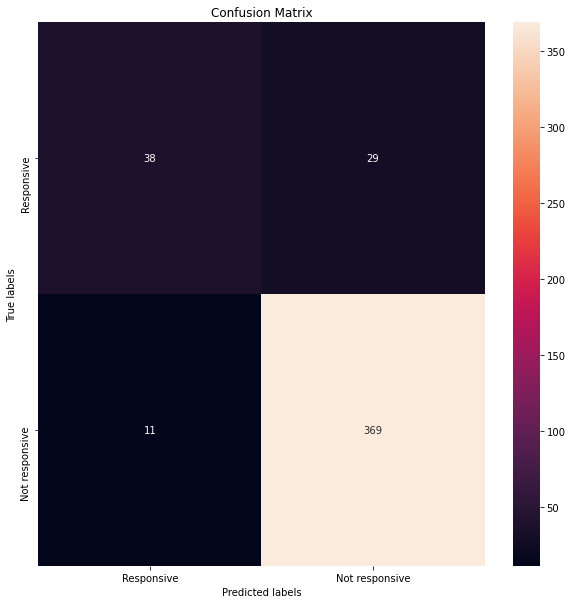

In [40]:
# confusion marix for the test data
cm = confusion_matrix(y_test, prediction,  labels=[1,0])

fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', ax = ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Responsive','Not responsive']); 
ax.yaxis.set_ticklabels(['Responsive','Not responsive']);

### C. Cumulative Gains and Lift charts<a class="anchor" id="section_3_3"></a>

In addition to the confusion matrix and F1-score, we can use two other meaningful metrics to measure the efficiency of our model : Cumulative gains and the lift chart.
- **Cumulative gains :** by ordering customers with the highest probability of accepting the marketing offer, it shows the proportion of customers that would be converted considering a sample size. 
- **Lift chart :** the lift is a measure of the performance of a targeting model at classifying cases as having an enhanced response, measured against a random choice targeting model

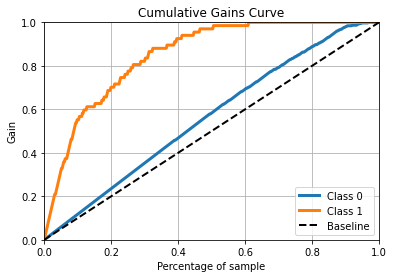

In [41]:
predicted_probabilities = pipe.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, predicted_probabilities);

If we target only the **top 20%** of customers, we would expect to convert almost **80%** of the total customers that would actually accept our marketing campaign offer.  
The diagonal line is the "baseline" curve, if we select 10% of the customers at random, we would expect to "gain" approximately 10% of all of the cases that actually accepted the marketing campaign offer.

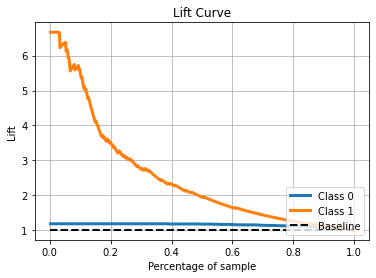

In [42]:
skplt.metrics.plot_lift_curve(y_test, predicted_probabilities);

From the lift chart, we can see that by targeting 20% of customers, the model addresses almost **4 times** more targets for this group, compared with addressing without the model, meaning randomly.